In [1]:
modelName = 'dpn98'
filterName = 'normalize'

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchvision import transforms
from torchvision.io import read_image

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import random
import os

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        
        self.device = device
        
        self.transform = transform

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        if idx >= len(self): raise StopIteration

        img = read_image(self.df.loc[idx, 'img_path'])[:3,:,:]
        filename = self.df.loc[idx, 'filename']
        sign = self.df.loc[idx, 'sign']
        
        if self.transform:
            img = self.transform(img)

        return img, filename, sign
    
    def getData(self):
        return list(self)

In [7]:
def createDataFrame():
    
    train_df = pd.read_csv('../../data/train.csv')
    train_df['img_path'] = '../../data/avia-train/avia-train/' + train_df['filename'] + '.png'
    
    test_df = pd.read_csv('../../data/test.csv')
    test_df['img_path'] = '../../data/avia-test/avia-test/' + test_df['filename'] + '.png'
    test_df['sign'] = -1
    
    test_e_df = pd.read_csv('../../data/test_extended.csv', index_col='filename')
    
    test_e_df = test_e_df.drop(test_df['filename'])
    test_e_df['filename'] = test_e_df.index
    
    test_e_df['img_path'] = '../../data/avia-test-extended/avia-test-extended/' + test_e_df['filename'] + '.jpeg'
    test_e_df['sign'] = -1
    
    df = pd.concat((train_df, test_df, test_e_df)).reset_index(drop=True)
    
    df['sign'] = df['sign'].astype('float64')
    
    return df

In [8]:
def createDataLoader(df, batch_size=None, shuffle=False, transform=None):

    batch_size = batch_size if batch_size else len(df)
    
    dataset = CustomImageDataset(df, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return dataset, dataloader

In [9]:
df = createDataFrame()

In [10]:
model = torch.hub.load('rwightman/pytorch-dpn-pretrained', 'dpn98', pretrained=True)
    
model.classifier = torch.nn.Sequential(
    nn.Conv2d(model.classifier.in_channels, 1, kernel_size=(1, 1), stride=(1, 1)),
    nn.Sigmoid()
)

weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

Using cache found in C:\Users\Sergey/.cache\torch\hub\rwightman_pytorch-dpn-pretrained_master


In [11]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestEpoch':0}
    
    epochs = 35
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.Resize(33),
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=250, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.Resize(33),
        transforms.ToPILImage(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=40, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device).float().reshape(-1, 1)
            
            y_predict = model(X)

            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:

            X, y = X.to(device), y.to(device).float()

            y_predicted1 = model(X)
            y_predicted2 = model(transforms.RandomHorizontalFlip(p=1)(X))
            y_predicted3 = model(transforms.RandomVerticalFlip(p=1)(X))
            y_predicted4 = model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X)))

            y_predict = torch.cat((y_predicted1, y_predicted2, y_predicted3, y_predicted4), dim=1).mean(dim=1)

            loss = criterion(y_predict, y)
            running_loss += loss.item()


        log['loss']['val'].append(running_loss/len(val_dataloader))

        if not log['bestEpoch'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            torch.save(model.state_dict(), f'./models/{modelName}_{filterName}.pt')
            log['bestEpoch'] = epoch

        print(f"Epoch: {epoch+1} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 1 / 35 | Train loss: 0.022028438167180867 | Val loss: 0.009152879140366657
Epoch: 2 / 35 | Train loss: 0.007171961814165116 | Val loss: 0.004762910403000065
Epoch: 3 / 35 | Train loss: 0.005351643437170424 | Val loss: 0.004130394759461827
Epoch: 4 / 35 | Train loss: 0.003456970585684758 | Val loss: 0.004030597348761288
Epoch: 5 / 35 | Train loss: 0.00307608473856817 | Val loss: 0.003840356996685538
Epoch: 6 / 35 | Train loss: 0.0023347245040349664 | Val loss: 0.0037127198548916615
Epoch: 7 / 35 | Train loss: 0.0024061308504315093 | Val loss: 0.003915624518086611
Epoch: 8 / 35 | Train loss: 0.0017370022980321665 | Val loss: 0.0038086194340277682
Epoch: 9 / 35 | Train loss: 0.0018360696639138042 | Val loss: 0.0041574549600810334
Epoch: 10 / 35 | Train loss: 0.0014926435423330987 | Val loss: 0.004127669473093239
Epoch: 11 / 35 | Train loss: 0.0015458199754357338 | Val loss: 0.005662457399548424
Epoch: 12 / 35 | Train loss: 0.0015825264598970535 | Val loss: 0.004143840304597035
Epoc

15


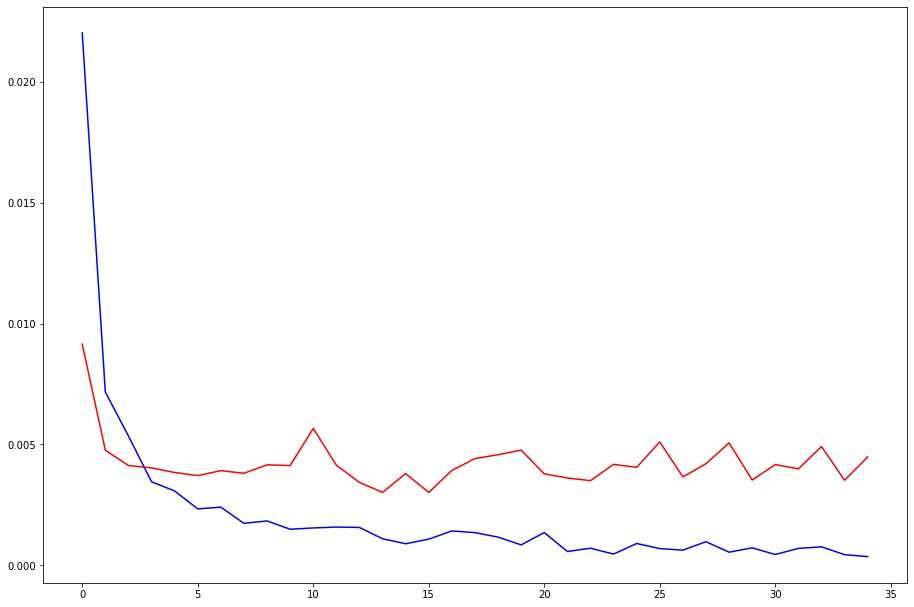

In [12]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [13]:
model = torch.hub.load('rwightman/pytorch-dpn-pretrained', 'dpn98', pretrained=True)
    
model.classifier = torch.nn.Sequential(
    nn.Conv2d(model.classifier.in_channels, 1, kernel_size=(1, 1), stride=(1, 1)),
    nn.Sigmoid()
)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}.pt'))

Using cache found in C:\Users\Sergey/.cache\torch\hub\rwightman_pytorch-dpn-pretrained_master


<All keys matched successfully>

In [14]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df.copy()
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.Resize(33),
        transforms.ToPILImage(),

        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=40, shuffle=True, transform=testTransform)
    
    filenames = []
    sign = []
    predicteds = [[], [], [], []]
    
    for X, filename, y in test_dataloader:

        X = X.to(device)
        
        predicteds[0].append(model(X).reshape(-1).cpu())
        predicteds[1].append(model(transforms.RandomHorizontalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[2].append(model(transforms.RandomVerticalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[3].append(model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X))).reshape(-1).cpu())
        
        sign.append(y)
        filenames += filename
        
predicteds[0] = torch.cat(predicteds[0], 0)
predicteds[1] = torch.cat(predicteds[1], 0)
predicteds[2] = torch.cat(predicteds[2], 0)
predicteds[3] = torch.cat(predicteds[3], 0)

sign = torch.cat(sign)

Wall time: 12min 33s


In [15]:
predict_df1 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'v': 0,
    
    'predict': predicteds[0],
    'sign': sign,
})

predict_df2 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'v': 1,
    
    'predict': predicteds[1],
    'sign': sign,
})

predict_df3 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'v': 2,
    
    'predict': predicteds[2],
    'sign': sign,
})

predict_df4 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'v': 3,
    
    'predict': predicteds[3],
    'sign': sign,
})

In [16]:
predict_df = pd.concat((predict_df1, predict_df2, predict_df3, predict_df4)).reset_index(drop=True)

In [17]:
predict_df

filename  model     filter  v   predict  \
0       5403d600-b2e2-4931-b619-662fe0dba4e5  dpn98  normalize  0  0.000094   
1       3710b8bc-3810-46c5-aef1-1477ffbcf9be  dpn98  normalize  0  0.000104   
2       23497501-acd3-419e-a5d2-d63759953f67  dpn98  normalize  0  0.000106   
3       f0c2bab2-62c5-4361-be03-5b9f73fe8bb0  dpn98  normalize  0  0.000176   
4       860a3a05-b491-4f6c-b0fa-c4f66dca16a2  dpn98  normalize  0  0.000112   
...                                      ...    ...        ... ..       ...   
528315  17333c2e-e7d7-49f1-99ec-ccf0233c37cf  dpn98  normalize  3  0.000098   
528316  3e6b9dca-5af7-4cc0-9d33-2442d211de55  dpn98  normalize  3  0.000050   
528317  4d123703-ef52-49d6-8351-b5eb9bddb615  dpn98  normalize  3  0.997482   
528318  320ef73c-cfb7-4d3b-b119-de00cb76a0cb  dpn98  normalize  3  0.999980   
528319  f45c0f5e-4b81-4c56-8c5f-6b56822e4090  dpn98  normalize  3  0.000079   

        sign  
0       -1.0  
1       -1.0  
2       -1.0  
3        0.0  
4       -1.0  
...      ...  
528315  -1.0  
528316   0.0  
528317   1.0  
528318   1.0  
528319   0.0  

[528320 rows x 6 columns]

In [18]:
predict_df.to_csv(f'predicteds/{modelName}_{filterName}.csv', index=False)